## segmentation of gp135 signal (from fixed images)
Vipul wrote this set of code (gp135_segmentation_2D), here I've modified it so that a z-slice that's *already* chosen is loaded, segmented and analyzed

### import packages

In [1]:
%matplotlib inline
import numpy as np
import skimage.io as io
io.use_plugin('tifffile')
from skimage.filters import threshold_otsu, threshold_local, rank, threshold_li,median
from skimage.measure import regionprops, find_contours
from skimage.transform import rescale
#from skimage.feature import peak_local_max
import cv2
from scipy import ndimage, interpolate
from skimage.morphology import reconstruction, label, disk, binary_opening,binary_closing, binary_dilation, skeletonize, thin, medial_axis, convex_hull_image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance as dist
from gp135_segmentation_functions import * 

### Table of Contents
1. [Load a dataset](#load)
2. [Segment gp135 lumen](#segment)
3. [Fourier contour fitting of a segmented lumen](#fourier)
4. [Jump to plotting](#plotting)

### Load a dataset <a id="load" />

In [2]:
input_dir = '/Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_z_slice/'
output_dir = '/Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/'
# cyst_dir = '/Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/cyst_z_slice_seg/'
home_dir = '/Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/'
df_fn = pd.read_csv(input_dir + 'z_slice_pixRes.csv')

In [8]:
df_fn.head()

,filename,x,y,z,x_um,y_um,z_um,xy_res,z_res
0,MDCK_Rab11a-GFP_4d 201201_01 z45.tif,644,644,4,53.1370,53.1370,1.5505,0.0825,0.3876
1,MDCK_Rab11a-GFP_4d 201201_02 z47.tif,644,644,4,53.1370,53.1370,1.9994,0.0825,0.4999
2,MDCK_Rab11a-GFP_4d 201201_03 z38.tif,516,516,4,42.5096,42.5096,1.9994,0.0824,0.4999
3,MDCK_Rab11a-GFP_4d 201201_04 z41.tif,644,644,4,53.1370,53.1370,1.9994,0.0825,0.4999
4,MDCK_Rab11a-GFP_4d 201201_05 z41.tif,644,644,4,53.1370,53.1370,1.9994,0.0825,0.4999


In [12]:
gp135.shape

(756, 756)

### segment gp135 [lumen]

In [13]:
start_z = 0
# for i in range(start_z, 1):
for i in range(start_z, len(df_fn)):
    fn =df_fn.iloc[i]['filename']
    fn_root = fn[:-4]
    gp135 = io.imread(input_dir + fn)
    if len(gp135.shape)>2:
        ch = 1 # this specifies which channel is the gp135 channel
        gp135 = gp135[:, :, ch] 
#         if np.sum(gp135[:, :, 0]) >0:
#             =0
#         elif np.sum(gp135[:, :, 1]) >0:
#             z=1
#         elif np.sum(gp135[:, :, 2]) >0:
#             z=2
#         else:
#             z=3
#         gp135 = gp135[:, :, z]   
    
    ## thresholding
    # determine local and otsu thresholds
    gp135_local_thr = gp135.copy()
    gp135_otsu_thr = gp135.copy()
    thr_local = threshold_local(gp135, 101)
    thr_otsu = threshold_otsu(gp135)

    # apply thresholds
    gp135_local_thr = gp135 > thr_local
    gp135_otsu_thr = gp135 > thr_otsu
    gp135_full_thr = (gp135_local_thr)*(gp135_otsu_thr)
    
    ## morphological processing
    # closing to get rid of speckles
    disk_size=1
    gp135_open = binary_opening(gp135_full_thr, selem=disk(disk_size))

    # skeletonize to get starting points for reconstruction
    gp135_skel = thin(gp135_open)

    # remove dots in skeleton
    gp135_skel_filt = throw_away_small_blobs(gp135_skel)
    
    # morphological reconstruction
    gp135_reconstruct = gp135_open.copy()
    gp135_reconstruct = reconstruction(gp135*gp135_skel_filt,gp135)
    
    # determine local and otsu thresholds
    gp135_local_thr_2 = gp135_reconstruct.copy()
    gp135_otsu_thr_2 = gp135_reconstruct.copy()
    thr_local_2 = threshold_local(gp135_reconstruct, 101)
    thr_otsu_2 = threshold_otsu(gp135_reconstruct)

    # apply thresholds
    gp135_local_thr_2 = gp135_reconstruct > thr_local_2
    gp135_otsu_thr_2 = gp135_reconstruct > thr_otsu_2
    gp135_full_thr_2 = (gp135_local_thr_2)*(gp135_otsu_thr_2)
    gp135_full_thr_2 = throw_away_small_blobs(gp135_full_thr_2)
    
    # dilate to close up close holes
    gp135_full_thr_dil = binary_dilation(binary_dilation(gp135_full_thr_2))

    # fill holes to fill in lumens
    gp135_full_thr_dil_fill = ndimage.binary_fill_holes(gp135_full_thr_dil)
    # erode to counteract the artificial thickening from dilation/smoothen the edges
    gp135_seg = ndimage.binary_erosion(gp135_full_thr_dil_fill)

    #plt.imshow(gp135, cmap='Greys_r', interpolation='nearest')
    #plt.imshow(gp135_seg, alpha=0.4, interpolation='nearest')
    #plt.title('segmented gp135 overlay raw')

    # save segmented image
    io.imsave(output_dir + fn_root + '_seg.tif', np.uint8(gp135_seg))
    
    print('done with ' + fn_root)

/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_01 z45_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_01 z45


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_02 z47_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_02 z47


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_03 z38_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_03 z38


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_04 z41_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_04 z41


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_05 z41_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_05 z41


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_06 z28_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_06 z28


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_06 z51_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_06 z51


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_07 z32_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_07 z32


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_08 z36_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_08 z36


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_09 z34_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_09 z34


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Rab11a-GFP_4d 201201_10 z34_seg.tif is a low contrast image


done with MDCK_Rab11a-GFP_4d 201201_10 z34


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_01 z39_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_01 z39


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_02 z44_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_02 z44


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_04 z20_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_04 z20


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_05 z29_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_05 z29


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_09 z30_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_09 z30


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_11 z31_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_11 z31


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_2d 201201_12 z27_seg.tif is a low contrast image


done with MDCK_Sec10_KD_2d 201201_12 z27


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_4d 201201_01 z45_seg.tif is a low contrast image


done with MDCK_Sec10_KD_4d 201201_01 z45


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_4d 201201_02 z47_seg.tif is a low contrast image


done with MDCK_Sec10_KD_4d 201201_02 z47


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_4d 201201_03 z72_seg.tif is a low contrast image


done with MDCK_Sec10_KD_4d 201201_03 z72


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_4d 201201_04 z42_seg.tif is a low contrast image


done with MDCK_Sec10_KD_4d 201201_04 z42


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_KD_4d 201201_06 z45_seg.tif is a low contrast image


done with MDCK_Sec10_KD_4d 201201_06 z45


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_01 z31_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_01 z31


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_02 z27_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_02 z27


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_04 z23_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_04 z23


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_05 z25_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_05 z25


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_06 z19_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_06 z19


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_07 z29_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_07 z29


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_08 z27_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_08 z27


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_09 z21_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_09 z21


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_2d 201201_10 z24_seg.tif is a low contrast image


done with MDCK_Sec10_OE_2d 201201_10 z24


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_4d 201201_01 z37_seg.tif is a low contrast image


done with MDCK_Sec10_OE_4d 201201_01 z37


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_4d 201201_02 z41_seg.tif is a low contrast image


done with MDCK_Sec10_OE_4d 201201_02 z41


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_4d 201201_03 z33_seg.tif is a low contrast image


done with MDCK_Sec10_OE_4d 201201_03 z33


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_4d 201201_04 z31_seg.tif is a low contrast image


done with MDCK_Sec10_OE_4d 201201_04 z31
done with MDCK_Sec10_OE_4d 201201_07 z36


/opt/anaconda3/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: /Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/new_MDCK_data/201201 MDCK_Mostov/201201_seg/MDCK_Sec10_OE_4d 201201_07 z36_seg.tif is a low contrast image


### segment gp135 [cyst]
Vipul does this and sends the data to me :P

### get contour and fourier fit to contour  <a id="fourier" />

In [14]:
# choosing if getting lumen or cyst contour
cyst_lumen = input('Do you want get fit for the lumen or the cyst? \n')

Do you want get fit for the lumen or the cyst? 
lumen


starting MDCK_Rab11a-GFP_4d 201201_01 z45


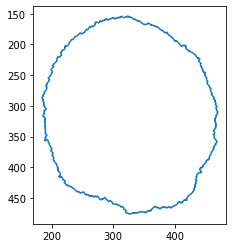

area: 69245.5
perimeter: 940.6837549800525
crude perimeter: 1204.937300352352
Isoperimetric Quotient: 0.9833636064722907
convex area: 71456.5
solidity: 0.9690580982835711
convex perimeter: 1269.6093887491538
GC: 1.307905290498305
done with MDCK_Rab11a-GFP_4d 201201_01 z45
starting MDCK_Rab11a-GFP_4d 201201_02 z47


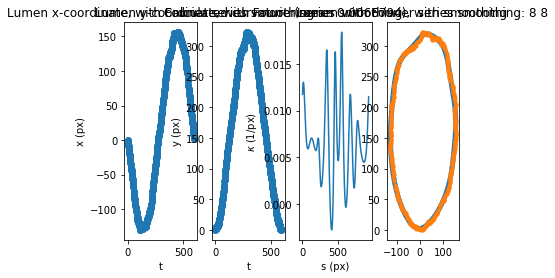

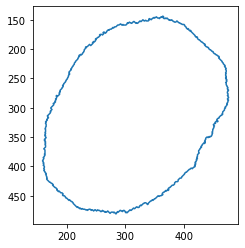

area: 75950.0
perimeter: 999.7907114731469
crude perimeter: 1247.079435976083
Isoperimetric Quotient: 0.9548154701843932
convex area: 77784.5
solidity: 0.976415609793725
convex perimeter: 2065.036319293198
GC: 2.0167557807952425
done with MDCK_Rab11a-GFP_4d 201201_02 z47
starting MDCK_Rab11a-GFP_4d 201201_03 z38


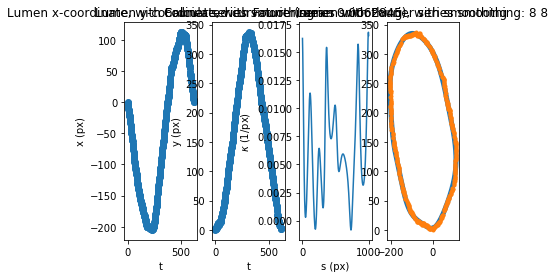

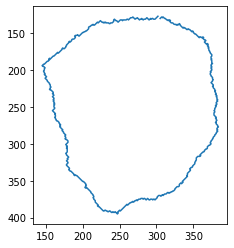

area: 45923.0
perimeter: 780.5076707553662
crude perimeter: 991.2316728675789
Isoperimetric Quotient: 0.9472961322975444
convex area: 48042.0
solidity: 0.9558927605012281
convex perimeter: 1078.5851843966707
GC: 1.3209502071271875
done with MDCK_Rab11a-GFP_4d 201201_03 z38
starting MDCK_Rab11a-GFP_4d 201201_04 z41


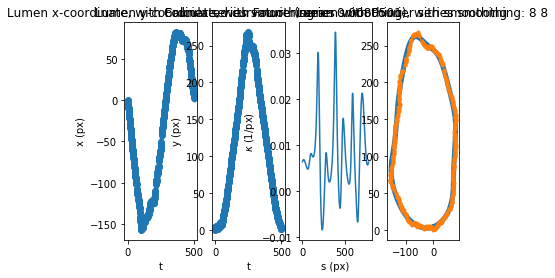

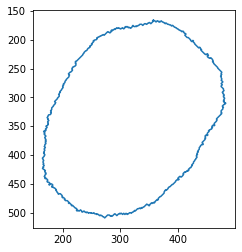

area: 76507.5
perimeter: 1004.280773224586
crude perimeter: 1287.275395468977
Isoperimetric Quotient: 0.9532428982329165
convex area: 78504.5
solidity: 0.9745619677852861
convex perimeter: 1780.0452241446003
GC: 1.7273698975826348
done with MDCK_Rab11a-GFP_4d 201201_04 z41
starting MDCK_Rab11a-GFP_4d 201201_05 z41


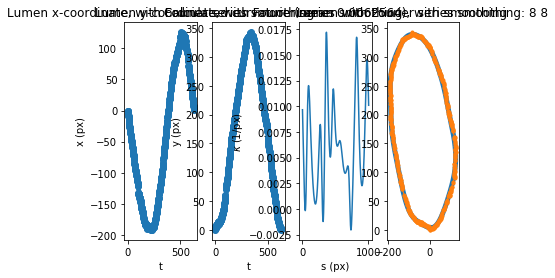

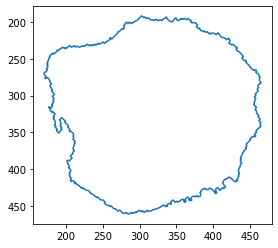

area: 57677.5
perimeter: 884.7627797599971
crude perimeter: 1266.7068529740525
Isoperimetric Quotient: 0.9258968424275078
convex area: 61876.5
solidity: 0.9321390188520682
convex perimeter: 1136.9841687552207
GC: 1.1978660628121327
done with MDCK_Rab11a-GFP_4d 201201_05 z41
starting MDCK_Rab11a-GFP_4d 201201_06 z28


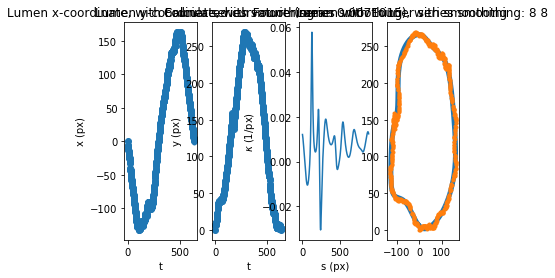

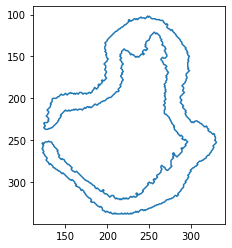

area: 12989.5
perimeter: 1140.848830777808
crude perimeter: 1587.3952365161228
Isoperimetric Quotient: 0.1254140217686567
convex area: 33701.5
solidity: 0.38542794831090604
convex perimeter: 1118.3317933422084
GC: 0.37782072173827935
done with MDCK_Rab11a-GFP_4d 201201_06 z28
starting MDCK_Rab11a-GFP_4d 201201_06 z51


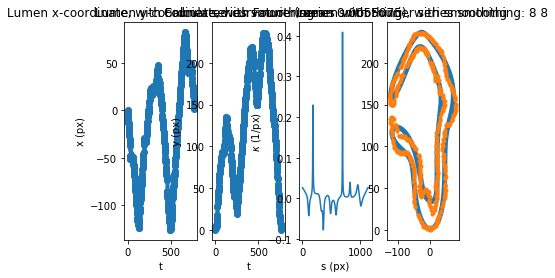

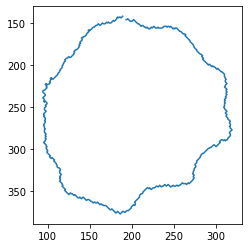

area: 36779.5
perimeter: 695.6103579822554
crude perimeter: 892.6631303726545
Isoperimetric Quotient: 0.9551764458828743
convex area: 39244.0
solidity: 0.937200591173173
convex perimeter: 866.3330768243817
GC: 1.1672164774944254
done with MDCK_Rab11a-GFP_4d 201201_06 z51
starting MDCK_Rab11a-GFP_4d 201201_07 z32


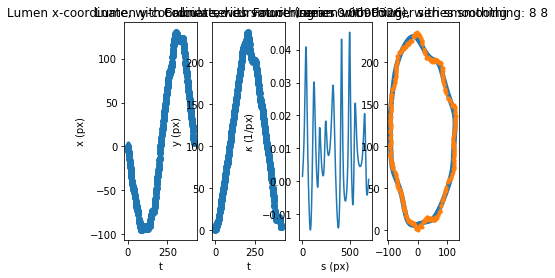

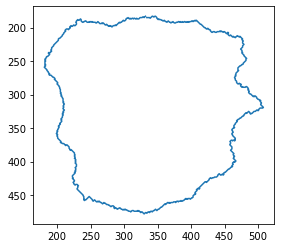

area: 68589.5
perimeter: 975.1400498284831
crude perimeter: 1333.7901140947383
Isoperimetric Quotient: 0.906428419663659
convex area: 75288.5
solidity: 0.9110222676770025
convex perimeter: 1342.5416194665997
GC: 1.2542663085495718
done with MDCK_Rab11a-GFP_4d 201201_07 z32
starting MDCK_Rab11a-GFP_4d 201201_08 z36


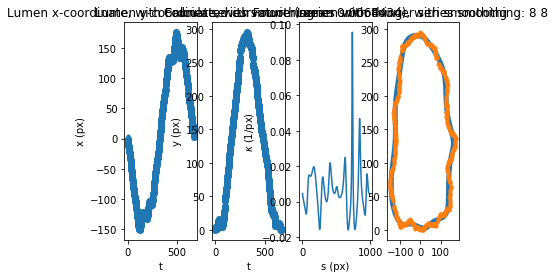

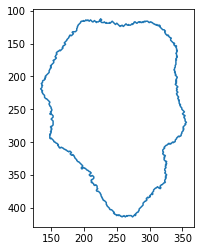

area: 45351.5
perimeter: 816.4064185556546
crude perimeter: 1078.314933988265
Isoperimetric Quotient: 0.8550444630628691
convex area: 48998.5
solidity: 0.9255691500760227
convex perimeter: 860.2174143784814
GC: 0.9752381693856176
done with MDCK_Rab11a-GFP_4d 201201_08 z36
starting MDCK_Rab11a-GFP_4d 201201_09 z34


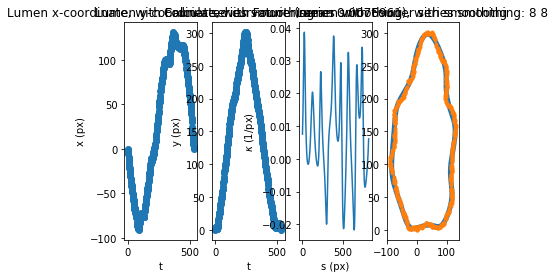

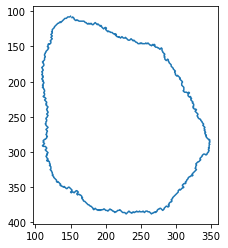

area: 48400.5
perimeter: 812.8169548181239
crude perimeter: 1065.6580797387726
Isoperimetric Quotient: 0.9206068539404458
convex area: 50565.5
solidity: 0.9571842461757523
convex perimeter: 795.3125171905696
GC: 0.9365707835308814
done with MDCK_Rab11a-GFP_4d 201201_09 z34
starting MDCK_Rab11a-GFP_4d 201201_10 z34


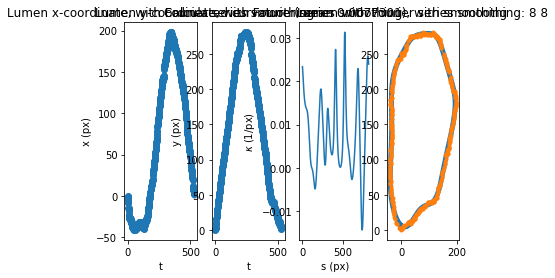

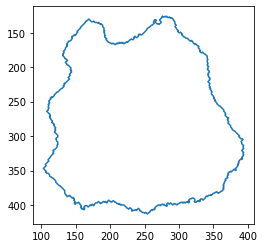

area: 58702.5
perimeter: 926.315167980055
crude perimeter: 1282.8611819066034
Isoperimetric Quotient: 0.8597039264825794
convex area: 65943.5
solidity: 0.8901938780926096
convex perimeter: 1275.8130740825632
GC: 1.2260632529805067
done with MDCK_Rab11a-GFP_4d 201201_10 z34
starting MDCK_Sec10_KD_2d 201201_01 z39


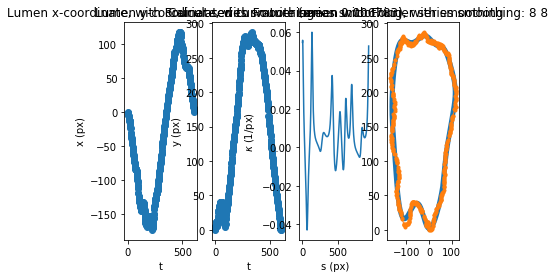

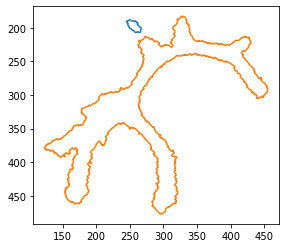

area: 237.0
perimeter: 64.38617536672547
crude perimeter: 66.42640687119282
Isoperimetric Quotient: 0.7184109674684154
convex area: 266.0
solidity: 0.8909774436090225
convex perimeter: 29.30870177950569
area: 19306.0
perimeter: 1196.2704192269312
crude perimeter: 1887.1668811788786
Isoperimetric Quotient: 0.16952878058844553
convex area: 60023.0
solidity: 0.3216433700414841
convex perimeter: 1328.105793978778
GC: 0.35709018335754755
done with MDCK_Sec10_KD_2d 201201_01 z39
starting MDCK_Sec10_KD_2d 201201_02 z44


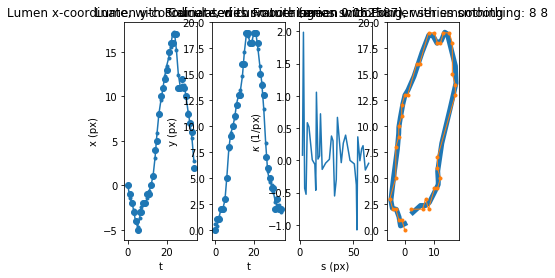

<Figure size 432x288 with 0 Axes>

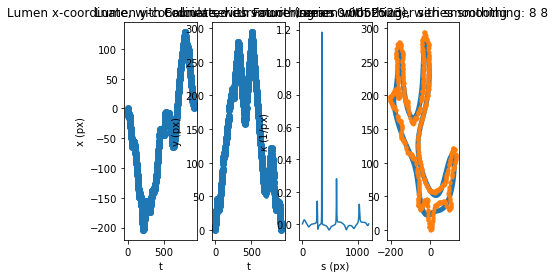

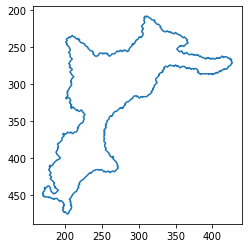

area: 19378.0
perimeter: 838.8635462516353
crude perimeter: 1283.7068529740527
Isoperimetric Quotient: 0.34604786288484296
convex area: 36694.0
solidity: 0.5280972366054396
convex perimeter: 1011.8097647285284
GC: 0.6369736092492578
done with MDCK_Sec10_KD_2d 201201_02 z44
starting MDCK_Sec10_KD_2d 201201_04 z20


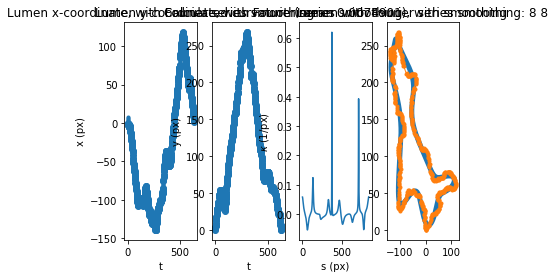

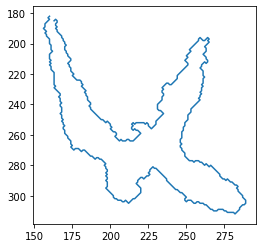

area: 5314.0
perimeter: 512.9217376292058
crude perimeter: 709.0163773909279
Isoperimetric Quotient: 0.2538219664220611
convex area: 12401.0
solidity: 0.4285138295298766
convex perimeter: 248.16325271885037
GC: 0.20732477875215333
done with MDCK_Sec10_KD_2d 201201_04 z20
starting MDCK_Sec10_KD_2d 201201_05 z29


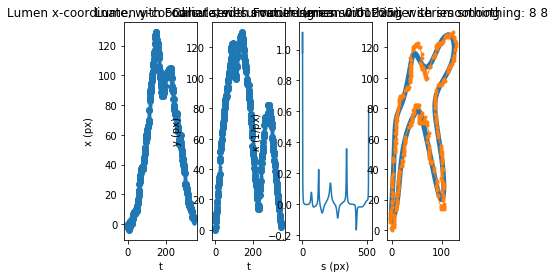

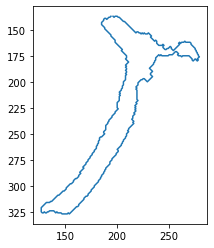

area: 4955.5
perimeter: 552.0355099082714
crude perimeter: 680.8742417671964
Isoperimetric Quotient: 0.20434467027081685
convex area: 13087.0
solidity: 0.3786582104378391
convex perimeter: 665.8505838399483
GC: 0.45672748576938493
done with MDCK_Sec10_KD_2d 201201_05 z29
starting MDCK_Sec10_KD_2d 201201_09 z30


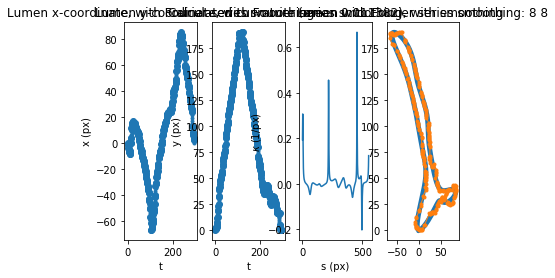

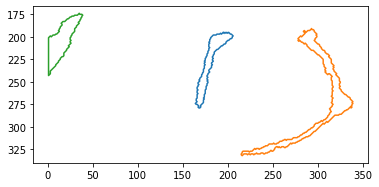

area: 822.0
perimeter: 196.77110844986103
crude perimeter: 232.49242404917516
Isoperimetric Quotient: 0.266783531637575
convex area: 1432.5
solidity: 0.5738219895287958
convex perimeter: 296.05742686174926
area: 1799.5
perimeter: 442.2042258960868
crude perimeter: 545.494516090229
Isoperimetric Quotient: 0.11564209154335774
convex area: 8596.5
solidity: 0.20932937823532832
convex perimeter: 537.7146083193203
area: 1027.5
perimeter: 166.38002578534218
crude perimeter: 183.82337649086296
Isoperimetric Quotient: 0.46643305476057073
convex area: 1180.5
solidity: 0.8703939008894537
convex perimeter: 185.22958726942088
GC: 0.9690027529601344
done with MDCK_Sec10_KD_2d 201201_09 z30
starting MDCK_Sec10_KD_2d 201201_11 z31


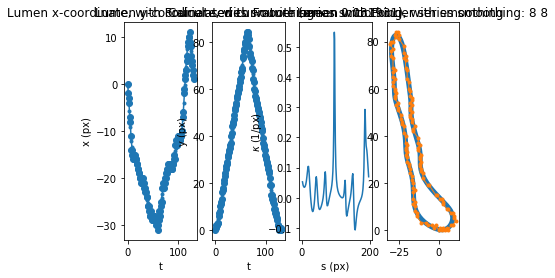

<Figure size 432x288 with 0 Axes>

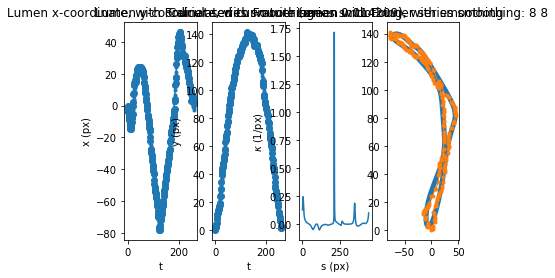

<Figure size 432x288 with 0 Axes>

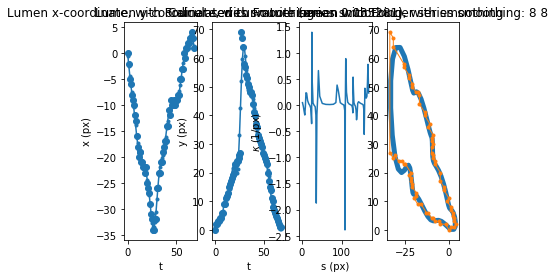

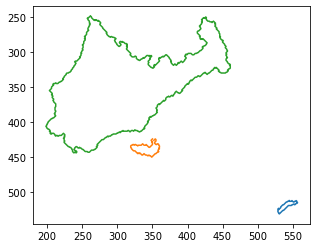

area: 170.5
perimeter: 71.48304587444501
crude perimeter: 79.39696961966997
Isoperimetric Quotient: 0.41930317269061607
convex area: 240.0
solidity: 0.7104166666666667
convex perimeter: 72.50517222929686
area: 520.0
perimeter: 112.22676228611942
crude perimeter: 135.82337649086276
Isoperimetric Quotient: 0.5188243373196737
convex area: 719.5
solidity: 0.7227241139680334
convex perimeter: 120.02916312296774
area: 23360.5
perimeter: 760.3777916714347
crude perimeter: 1125.4276323604731
Isoperimetric Quotient: 0.5077303799872149
convex area: 35450.5
solidity: 0.6589610865855207
convex perimeter: 749.8706555133358
GC: 0.6498553579129048
done with MDCK_Sec10_KD_2d 201201_11 z31
starting MDCK_Sec10_KD_2d 201201_12 z27


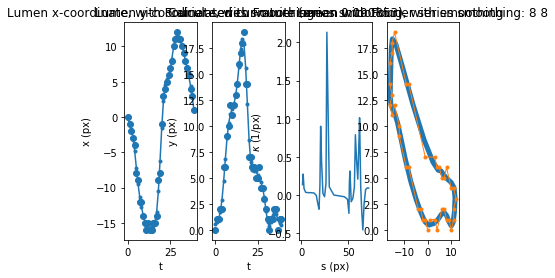

<Figure size 432x288 with 0 Axes>

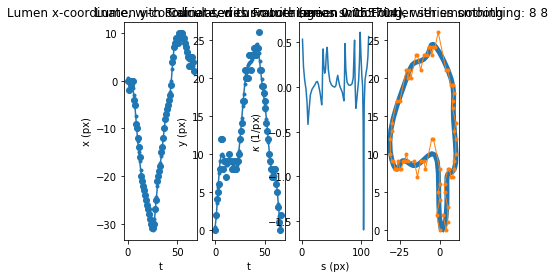

<Figure size 432x288 with 0 Axes>

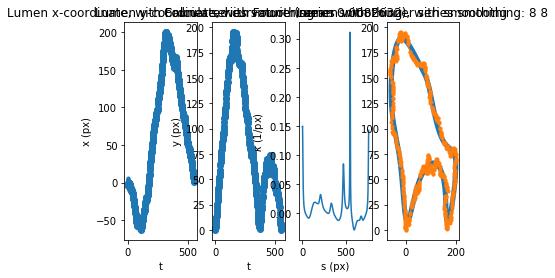

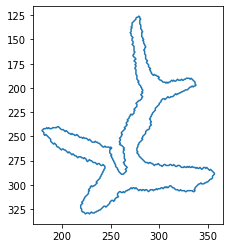

area: 7752.5
perimeter: 738.6522675643758
crude perimeter: 1034.2194795587595
Isoperimetric Quotient: 0.1785548158452851
convex area: 22526.5
solidity: 0.3441502230706057
convex perimeter: 658.5559961005594
GC: 0.3068320546958043
done with MDCK_Sec10_KD_2d 201201_12 z27
starting MDCK_Sec10_KD_4d 201201_01 z45


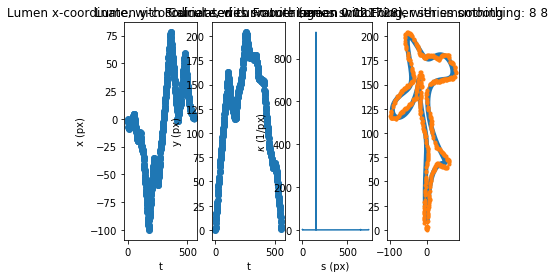

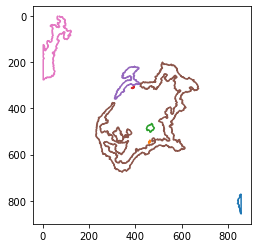

area: 677.5
perimeter: 218.93940932516563
crude perimeter: 198.7523086789973
Isoperimetric Quotient: 0.17761158070930766
convex area: 862.0
solidity: 0.7859628770301624
convex perimeter: 177.09884245810304
area: 52.5
perimeter: 41.36578275055788
crude perimeter: 34.87005768508881
Isoperimetric Quotient: 0.38555529684248757
convex area: 64.0
solidity: 0.8203125
convex perimeter: 35.38361202590826
area: 685.0
perimeter: 105.30483151767766
crude perimeter: 121.09545442950495
Isoperimetric Quotient: 0.7762539806774928
convex area: 813.5
solidity: 0.842040565457898
convex perimeter: 123.88300932734884
area: 44.5
perimeter: 34.70228711734195
crude perimeter: 31.798989873223338
Isoperimetric Quotient: 0.4643587972009926
convex area: 53.0
solidity: 0.839622641509434
convex perimeter: 32.817678162843876
area: 4517.5
perimeter: 465.72463052181155
crude perimeter: 640.2173875177043
Isoperimetric Quotient: 0.26172765352312627
convex area: 8381.0
solidity: 0.5390168237680468
convex perimeter: 598.9

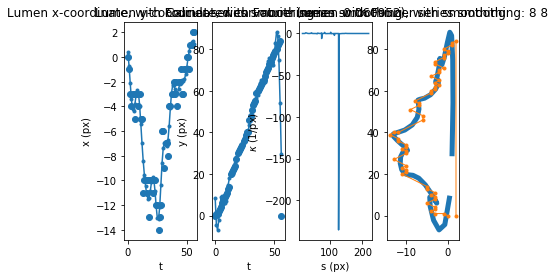

<Figure size 432x288 with 0 Axes>

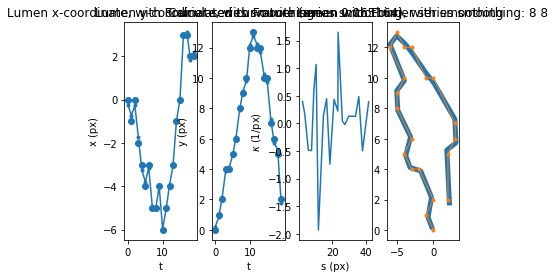

<Figure size 432x288 with 0 Axes>

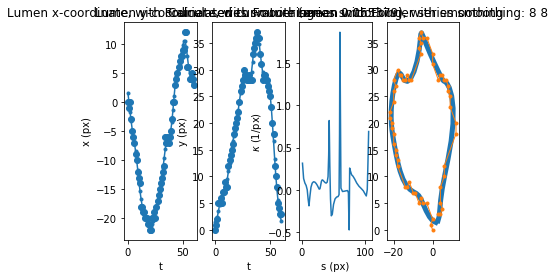

<Figure size 432x288 with 0 Axes>

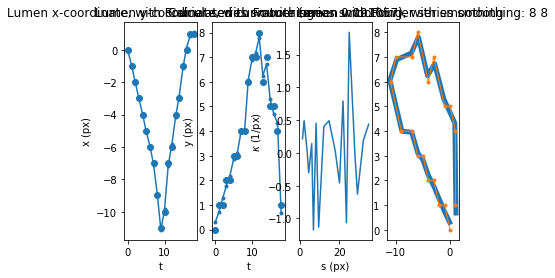

<Figure size 432x288 with 0 Axes>

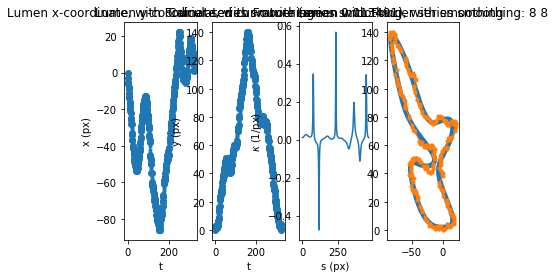

<Figure size 432x288 with 0 Axes>

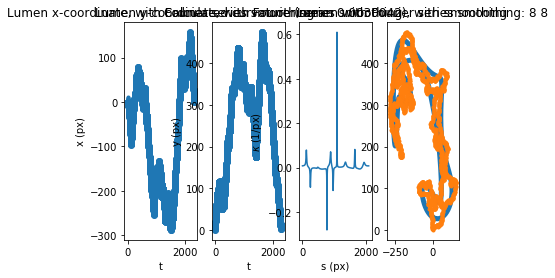

<Figure size 432x288 with 0 Axes>

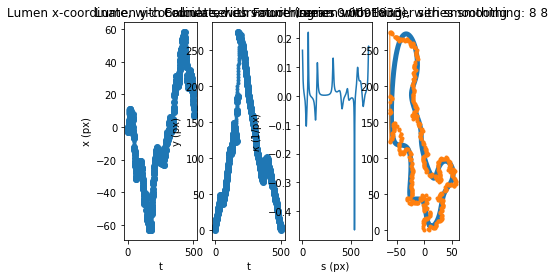

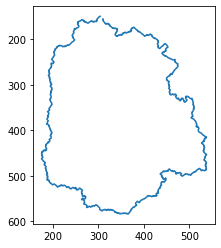

area: 106908.0
perimeter: 1260.9926607760747
crude perimeter: 1975.9780643609222
Isoperimetric Quotient: 0.8448798474563574
convex area: 119673.0
solidity: 0.8933343360657793
convex perimeter: 1488.2083187511082
GC: 1.054302401364393
done with MDCK_Sec10_KD_4d 201201_02 z47
starting MDCK_Sec10_KD_4d 201201_03 z72


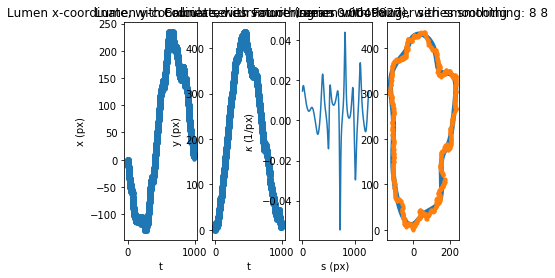

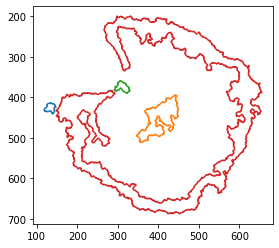

area: 444.0
perimeter: 90.86064151544339
crude perimeter: 104.953318805774
Isoperimetric Quotient: 0.675835867364661
convex area: 554.0
solidity: 0.8014440433212996
convex perimeter: 77.95511529078769
area: 5169.5
perimeter: 410.9947442577872
crude perimeter: 633.9453095790619
Isoperimetric Quotient: 0.38457926691995165
convex area: 7562.0
solidity: 0.6836154456492991
convex perimeter: 519.6797090516427
area: 593.5
perimeter: 108.9110783806796
crude perimeter: 138.7228714274745
Isoperimetric Quotient: 0.6287622666280996
convex area: 788.5
solidity: 0.7526949904882688
convex perimeter: 73.71566997592845
area: 48766.5
perimeter: 2486.4646943725534
crude perimeter: 4967.915723650687
Isoperimetric Quotient: 0.0991212698416089
convex area: 180114.5
solidity: 0.2707527711539049
convex perimeter: 1524.886553157316
GC: 0.16604589676945103
done with MDCK_Sec10_KD_4d 201201_03 z72
starting MDCK_Sec10_KD_4d 201201_04 z42


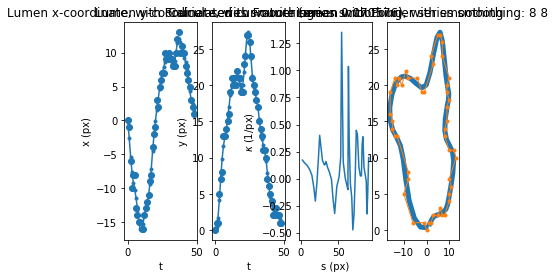

<Figure size 432x288 with 0 Axes>

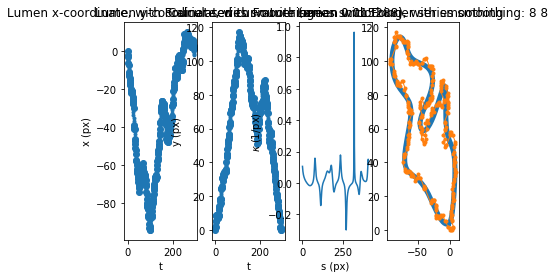

<Figure size 432x288 with 0 Axes>

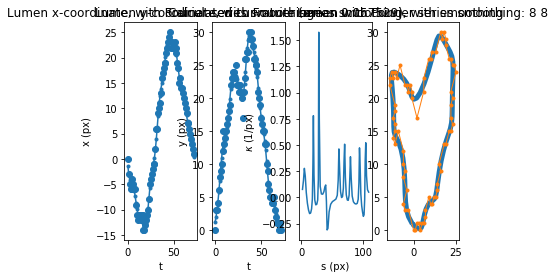

<Figure size 432x288 with 0 Axes>

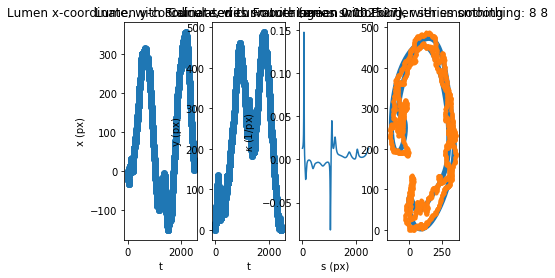

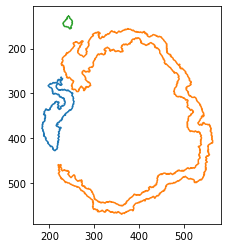

area: 4682.0
perimeter: 427.3126154962189
crude perimeter: 624.246824769227
Isoperimetric Quotient: 0.3222180344708295
convex area: 7464.0
solidity: 0.6272775991425509
convex perimeter: 586.8986283848344
area: 23703.0
perimeter: 1835.0834758776195
crude perimeter: 2862.817818242672
Isoperimetric Quotient: 0.08845075235408222
convex area: 112072.0
solidity: 0.211497965593547
convex perimeter: 1575.8540541560312
area: 342.5
perimeter: 75.57989384816362
crude perimeter: 81.3259018078045
Isoperimetric Quotient: 0.7534559808658292
convex area: 387.5
solidity: 0.8838709677419355
convex perimeter: 79.63039620647382
GC: 0.9312396693502352
done with MDCK_Sec10_KD_4d 201201_04 z42
starting MDCK_Sec10_KD_4d 201201_06 z45


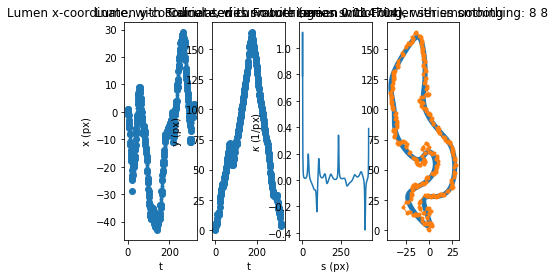

<Figure size 432x288 with 0 Axes>

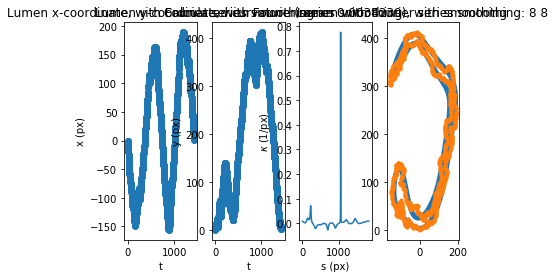

<Figure size 432x288 with 0 Axes>

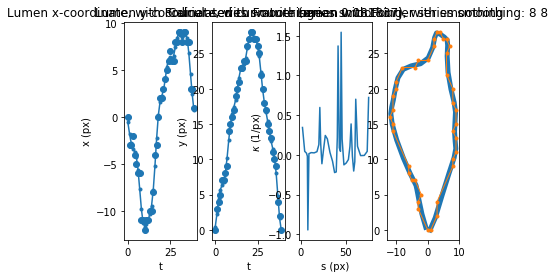

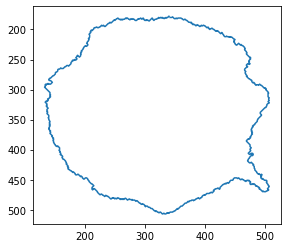

area: 89618.0
perimeter: 1130.3913340723911
crude perimeter: 1546.9099551418842
Isoperimetric Quotient: 0.8813481002918159
convex area: 98749.5
solidity: 0.9075286457146619
convex perimeter: 1557.5191812623048
GC: 1.2504459567584294
done with MDCK_Sec10_KD_4d 201201_06 z45
starting MDCK_Sec10_OE_2d 201201_01 z31


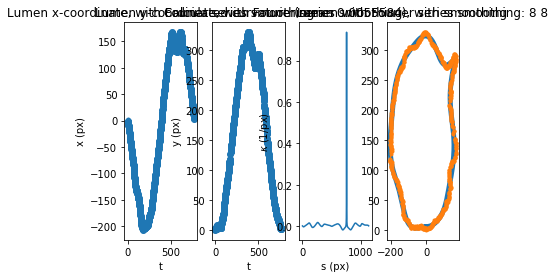

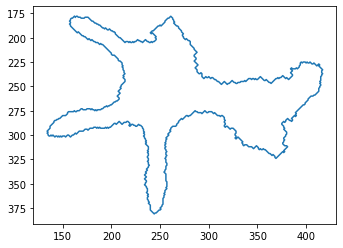

area: 17767.5
perimeter: 922.1863681394296
crude perimeter: 1320.4347750354111
Isoperimetric Quotient: 0.2625420015427565
convex area: 39652.0
solidity: 0.44808584686774944
convex perimeter: 598.4663733243498
GC: 0.2907918843497445
done with MDCK_Sec10_OE_2d 201201_01 z31
starting MDCK_Sec10_OE_2d 201201_02 z27


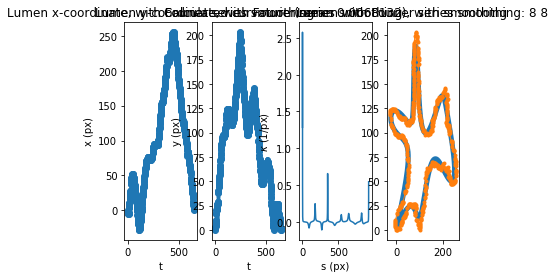

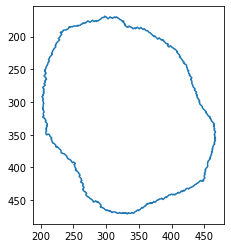

area: 56987.5
perimeter: 873.1173741703863
crude perimeter: 1076.9301576774144
Isoperimetric Quotient: 0.9393862706124118
convex area: 59115.0
solidity: 0.9640108263554089
convex perimeter: 1098.5290164579178
GC: 1.212888319783146
done with MDCK_Sec10_OE_2d 201201_02 z27
starting MDCK_Sec10_OE_2d 201201_04 z23


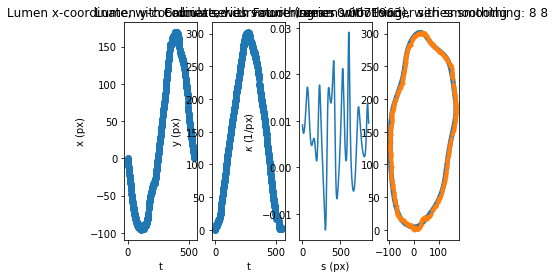

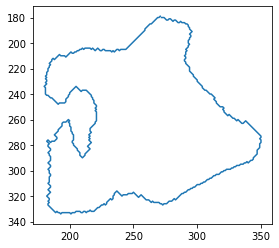

area: 15615.5
perimeter: 594.8438510578189
crude perimeter: 775.2001435750018
Isoperimetric Quotient: 0.5545743839804789
convex area: 19392.0
solidity: 0.8052547442244224
convex perimeter: 690.3825026751475
GC: 0.9345877655456435
done with MDCK_Sec10_OE_2d 201201_04 z23
starting MDCK_Sec10_OE_2d 201201_05 z25


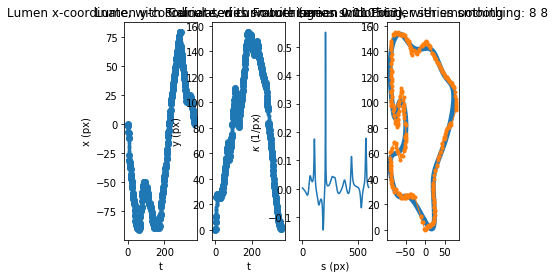

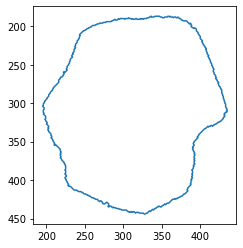

area: 43940.5
perimeter: 775.5199365687578
crude perimeter: 913.6265504461954
Isoperimetric Quotient: 0.9180977536128069
convex area: 46068.0
solidity: 0.9538182686463489
convex perimeter: 1207.3255567575798
GC: 1.4848995079791938
done with MDCK_Sec10_OE_2d 201201_05 z25
starting MDCK_Sec10_OE_2d 201201_06 z19


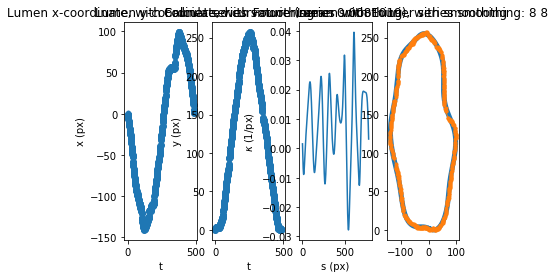

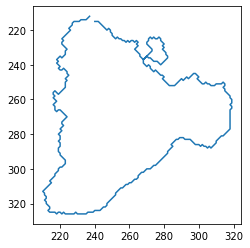

area: 6867.5
perimeter: 373.81849925460824
crude perimeter: 517.4945160902288
Isoperimetric Quotient: 0.6175710835277963
convex area: 8574.0
solidity: 0.8009680429204572
convex perimeter: 349.87569221081935
GC: 0.7496666136489647
done with MDCK_Sec10_OE_2d 201201_06 z19
starting MDCK_Sec10_OE_2d 201201_07 z29


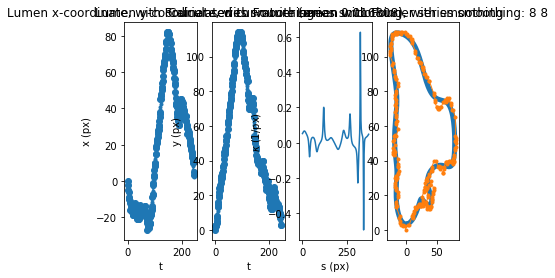

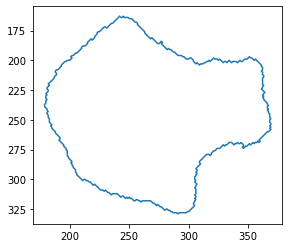

area: 19352.0
perimeter: 550.1346030949397
crude perimeter: 674.8742417671971
Isoperimetric Quotient: 0.8035220408659958
convex area: 22036.0
solidity: 0.8781993102196406
convex perimeter: 608.1636292972476
GC: 0.9708330956548563
done with MDCK_Sec10_OE_2d 201201_07 z29
starting MDCK_Sec10_OE_2d 201201_08 z27


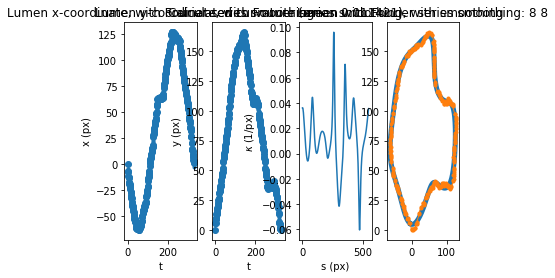

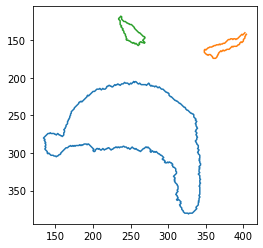

area: 16053.0
perimeter: 624.8989520726889
crude perimeter: 809.2417741353447
Isoperimetric Quotient: 0.5165905733272164
convex area: 23953.5
solidity: 0.6701734610808442
convex perimeter: 550.8084966664911
area: 577.5
perimeter: 135.11600635589343
crude perimeter: 153.23759005323592
Isoperimetric Quotient: 0.39751017719592874
convex area: 762.0
solidity: 0.7578740157480315
convex perimeter: 204.30124816065123
area: 547.5
perimeter: 108.91187124597906
crude perimeter: 128.16652224137044
Isoperimetric Quotient: 0.5800207731066608
convex area: 654.5
solidity: 0.8365164247517188
convex perimeter: 48.041648597857254
GC: 0.3689921738053112
done with MDCK_Sec10_OE_2d 201201_08 z27
starting MDCK_Sec10_OE_2d 201201_09 z21


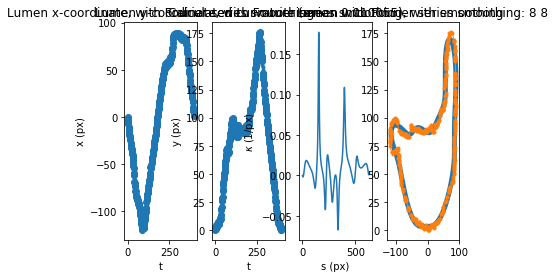

<Figure size 432x288 with 0 Axes>

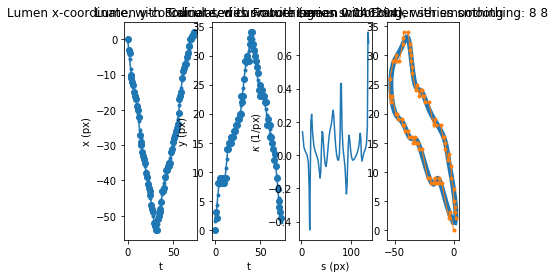

<Figure size 432x288 with 0 Axes>

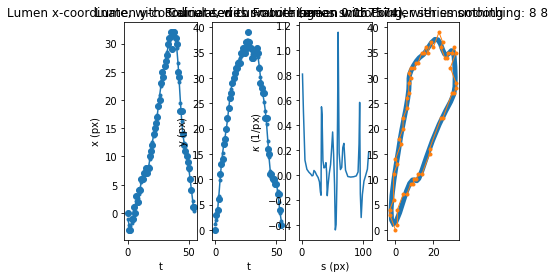

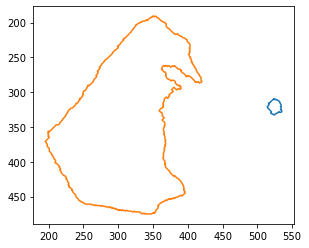

area: 308.0
perimeter: 67.86185132599759
crude perimeter: 75.56854249492378
Isoperimetric Quotient: 0.8404447599595722
convex area: 343.0
solidity: 0.8979591836734694
convex perimeter: 54.405882034941776
area: 35440.0
perimeter: 834.903854451985
crude perimeter: 1065.5037508062212
Isoperimetric Quotient: 0.6388967003183895
convex area: 43247.0
solidity: 0.8194788077785742
convex perimeter: 1330.7009431123133
GC: 1.3061159276684307
done with MDCK_Sec10_OE_2d 201201_09 z21
starting MDCK_Sec10_OE_2d 201201_10 z24


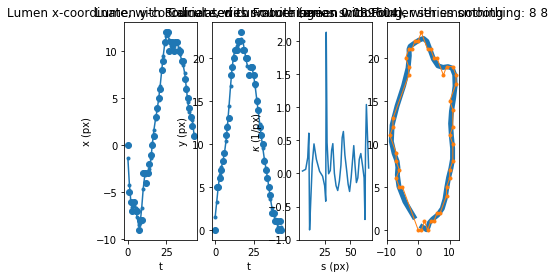

<Figure size 432x288 with 0 Axes>

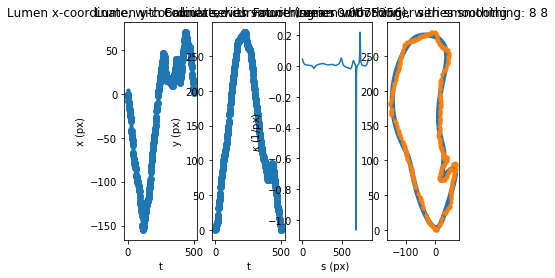

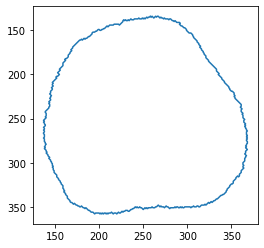

area: 39991.5
perimeter: 722.2369387498841
crude perimeter: 864.0529573173886
Isoperimetric Quotient: 0.9634255613922018
convex area: 40894.5
solidity: 0.9779187910354693
convex perimeter: 1143.7696446400385
GC: 1.548679897272333
done with MDCK_Sec10_OE_2d 201201_10 z24
starting MDCK_Sec10_OE_4d 201201_01 z37


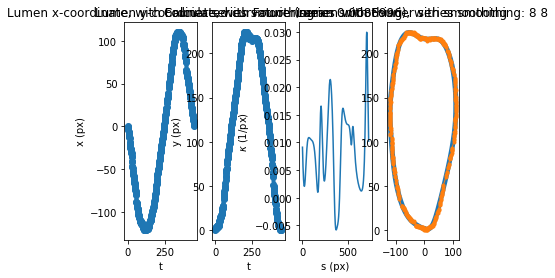

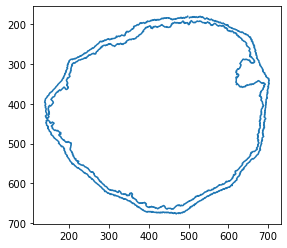

area: 23501.5
perimeter: 3018.631960007444
crude perimeter: 4222.306417147179
Isoperimetric Quotient: 0.0324104540010862
convex area: 210807.0
solidity: 0.11148348963744088
convex perimeter: 2800.3374796620496
GC: 0.10342148315241173
done with MDCK_Sec10_OE_4d 201201_01 z37
starting MDCK_Sec10_OE_4d 201201_02 z41


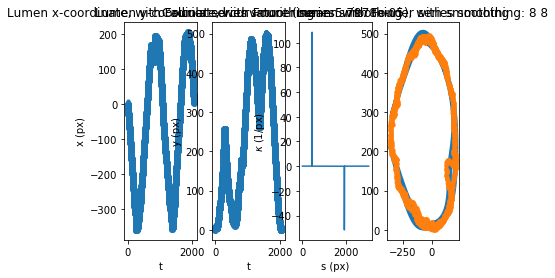

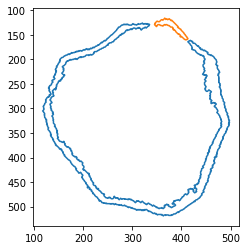

area: 16104.5
perimeter: 2007.5709144325494
crude perimeter: 2750.651296001308
Isoperimetric Quotient: 0.05021290177187949
convex area: 111274.5
solidity: 0.14472767794957514
convex perimeter: 1821.6187855860512
area: 762.5
perimeter: 169.264546548025
crude perimeter: 196.9777054234136
Isoperimetric Quotient: 0.334439609620756
convex area: 1270.0
solidity: 0.6003937007874016
convex perimeter: 64.52906321960671
GC: 0.22888929704940583
done with MDCK_Sec10_OE_4d 201201_02 z41
starting MDCK_Sec10_OE_4d 201201_03 z33


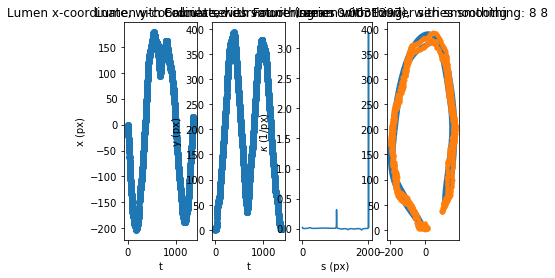

<Figure size 432x288 with 0 Axes>

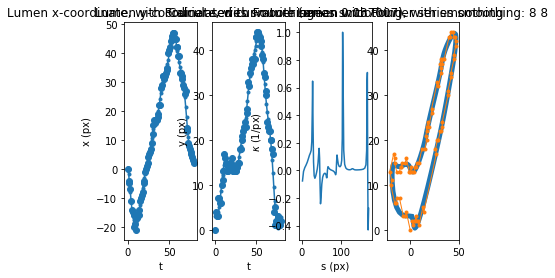

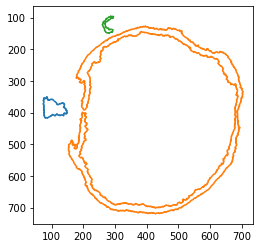

area: 3066.5
perimeter: 230.7951957470599
crude perimeter: 320.901586977665
Isoperimetric Quotient: 0.7234346473296523
convex area: 3771.0
solidity: 0.813179527976664
convex perimeter: 182.20043907740728
area: 35364.0
perimeter: 3292.1734387655197
crude perimeter: 4753.2811639777665
Isoperimetric Quotient: 0.04100207469796379
convex area: 261174.5
solidity: 0.13540372432990203
convex perimeter: 3317.6829263810005
area: 636.5
perimeter: 169.3766775766153
crude perimeter: 212.7350647362943
Isoperimetric Quotient: 0.27880531756684546
convex area: 1445.0
solidity: 0.4404844290657439
convex perimeter: 194.3939299463849
GC: 0.5055448038738811
done with MDCK_Sec10_OE_4d 201201_03 z33
starting MDCK_Sec10_OE_4d 201201_04 z31


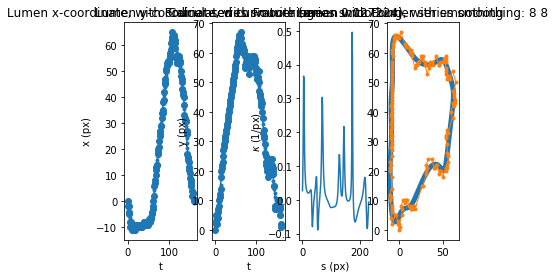

<Figure size 432x288 with 0 Axes>

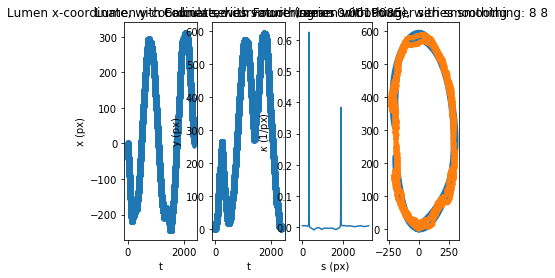

<Figure size 432x288 with 0 Axes>

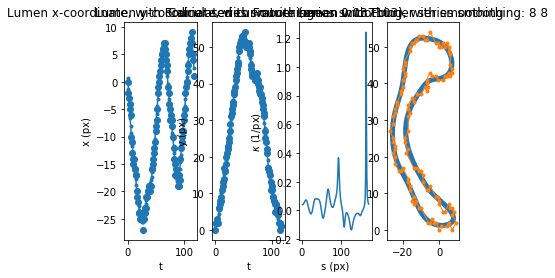

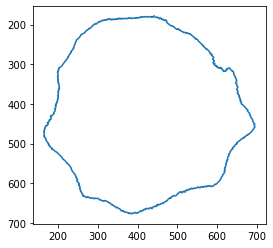

area: 182783.5
perimeter: 1556.1827067012434
crude perimeter: 1940.024745555147
Isoperimetric Quotient: 0.948474552763739
convex area: 191817.5
solidity: 0.9529031501296805
convex perimeter: 2378.3654050628975
GC: 1.4563533426277715
done with MDCK_Sec10_OE_4d 201201_04 z31


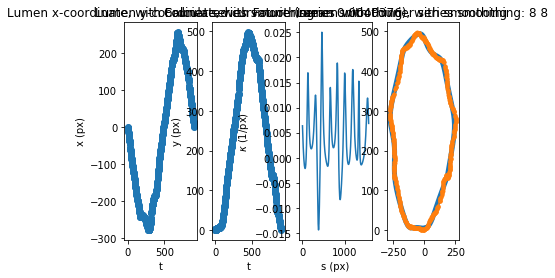

<Figure size 432x288 with 0 Axes>

In [15]:
start_z = 0
for i in range(start_z, len(df_fn)-1):
#for i in range(start_z, 1):
    #load gp135_seg (lumen or cyst segmentation)
    fn =df_fn.iloc[i]['filename']
    fn_root = fn[:-4]
    print('starting ' + fn_root)
    if cyst_lumen == 'lumen':
        gp135_seg = io.imread(output_dir + fn_root + '_seg.tif')
    else:
#         gp135_seg = io.imread(output_dir + fn_root + '_cyst_seg.tif')
        gp135_seg = io.imread(cyst_dir + fn_root + '_cyst.tif' )
    
    # find contour and plot
    imgray = np.uint8(gp135_seg)
    contours, hierarchy = cv2.findContours(imgray,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    all_contours = []
    for contour in contours:
    #     print contour.shape
        contourp = contour[:,0,:].T
    #     print contourp
        plt.plot(contourp[0,:],contourp[1,:])
        all_contours+= [contourp[:,:]]
    plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.show()
#     plt.savefig(fn_root + '_contour_plot.png')

    # go through contours and fit - save one with largest area
    ## simple parametrization
    #curve starts at 0,0
    areas = []
    perims = []
    ipqs = []
    areas_c = []
    soliditys = []
    perims_c = []
    for c in range(len(all_contours)):
        this_contour = all_contours[c]
        centroid = this_contour[:,0]
        relative = np.array([this_contour[0,:]-centroid[0],this_contour[1,:]-centroid[1]])
        #plt.plot(relative[0,:],relative[1,:])
        #plt.gca().set_aspect('equal')
        #plt.show()
        #plt.savefig(fn_root + '_contour_param_plot.png')

        ## fourier fit
        a, p, ipq, a_c, s, p_c, fx, fy = fit_fourier_param(relative,8,8,fn_root, show_plots=True);
        areas += [a]
        perims += [p]
        ipqs += [ipq]
        areas_c += [a_c]
        soliditys += [s]
        perims_c += [p_c]

    ## add area, perimeter & IPQ to dataframe
    # if multi-lumen, pick lumen with largest area
    big_id = areas.index(max(areas))
    A = areas[big_id]
    P = perims[big_id]
    IPQ = ipqs[big_id]
    A_c = areas_c[big_id]
    S = soliditys[big_id]
    P_c = perims_c[big_id]
    if i == 0:
        df_gp135 = pd.DataFrame(columns=list(['filename', 'area', 'perimeter', 'ipq', 'area_convex', 'solidity', 'perimeter_convex']))
    df_gp135.loc[i] = [fn_root, A, P, IPQ, A_c, S, P_c]
    
    print("GC:", (p_c/a_c)/(p/a))
    print("done with " + fn_root)

In [20]:
# determine radii by area and perimeter - and adjust to plot versus lumen radius
def radius_by_area(a, xy_res):
    return np.sqrt(a/np.pi)*xy_res

def radius_by_perimeter(p, xy_res):
    return 0.5*p/np.pi*xy_res

# # criteria of regularity -- from Giraud_JEI_GR.pdf ('Evaluation Framework of Superpixel Methods with a Global Regularity Measure') 
# def criteria_of_regularity(a, p, a_c, p_c):
#     cc = p/a
#     cc_c = p_c/a_c
#     return cc_c/cc
    
df_gp135['radius_a'] = radius_by_area(df_gp135['area'], df_fn[' xy_res'])
df_gp135['radius_p'] = radius_by_perimeter(df_gp135['perimeter'], df_fn[' xy_res'])
# df_gp135['cr'] = criteria_of_regularity(df_gp135['area'], df_gp135['perimeter'], df_gp135['area_convex'], df_gp135['perimeter_convex'])

In [24]:
# add condition to df_gp135
conditions = []
for i in range(len(df_gp135)):
    fn_root = df_gp135.filename[i]
    if fn_root.find('Cldn_qKO')>0:
        condition = 'Cldn_qKO'
    elif fn_root.find('PIP5K1b-GFP')>0:
        condition = 'PIP5K1b-GFP'
    elif fn_root.find('Rab11a-GFP')>0:
        condition = 'Rab11a-GFP'
    elif fn_root.find('Sec10_OE')>0:
        condition = 'Sec10_OE'
    elif fn_root.find('Sec10_KD')>0:
        condition = 'Sec10_KD'
    else:
        condition = 'WT'
    conditions += [condition]
df_gp135['condition'] = conditions

In [27]:
home_dir = '/Users/clauvasq/Documents/Python/lumen_curvature_2D/fixed_lumen_data/'
# save df_gp135
todays_date = '201201'
if cyst_lumen == 'lumen':
    df_gp135.to_csv(home_dir + 'gp135_seg_' + todays_date + '.csv')
else:
    # change columns names for cyst
    df_cyst = df_cyst.rename(columns={'area': 'area_cyst', 'perimeter': 'perimeter_cyst', 'IPQ':'ipq_cyst',
                                      'area_convex':'area_convex_cyst', 'soldity':'solidity_cyst', 
                                      'perimeter_convex': 'perimeter_convex_cyst',
                                      'radius_a':'radius_cyst_a', 'radius_p':'radius_p_cyst'})
    df_gp135.to_csv(home_dir + 'gp135_cyst_seg_' + todays_date + '.csv')